# ShopTalk — ABO EDA & Embedding Model Comparison

**Goal**: Load the Amazon Berkeley Objects (ABO) dataset metadata, run quick EDA, generate embeddings with multiple pretrained models, and compare retrieval quality & clustering.

**Output**:
- Cleaned product text (title + description + optional captions)
- Embeddings from several encoders (e5 / bge / MiniLM; easily extendable)
- Retrieval metrics (Recall@K, nDCG@K) on a small eval set
- Inter-/intra-category cosine analysis
- UMAP projection plots

> ⚠️ This notebook downloads data from the web (ABO) and models from Hugging Face. Run in an environment with internet (Colab/Kaggle) and a GPU for speed.

## 0. Setup

Configure your environment and pick which encoders to benchmark.

In [3]:
!pip -q install pandas numpy matplotlib umap-learn scikit-learn faiss-cpu sentence-transformers datasets rich

from pathlib import Path
import pandas as pd, numpy as np
from rich import print
from PIL import Image
from tqdm.auto import tqdm

import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip.eval()

DATA_DIR = Path("./data_abo")
META_DIR = DATA_DIR / "meta"
IMG_DIR  = DATA_DIR / "images_main"   # local cache of main images
META_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

# Choose encoders to compare
ENCODERS = {
    'e5-base': 'intfloat/e5-base-v2',
    'bge-base': 'BAAI/bge-base-en-v1.5',
    'MiniLM': 'sentence-transformers/all-MiniLM-L6-v2'
}
SEED = 42
np.random.seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 70.5 MB/s eta 0:00:00


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

## 1. Download ABO metadata (sample) & optional images

ABO host: https://amazon-berkeley-objects.s3.amazonaws.com/index.html  
We'll pull a metadata CSV/JSONL sample (titles, categories, descriptions, URLs).

In [4]:
import os
from pathlib import Path
import urllib.request

# DATA_DIR = Path("./data_abo")
# DATA_DIR.mkdir(parents=True, exist_ok=True)

url = "https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar"
tar_path = META_DIR / "abo-listings.tar"

if tar_path.exists() and tar_path.stat().st_size > 0:
    print("Using cached:", tar_path)
else:
    print("Downloading:", url)
    urllib.request.urlretrieve(url, str(tar_path))
    print("Saved to:", tar_path)
# A) Image metadata: maps image_id -> relative path
# If you don't have it yet, download:
# https://amazon-berkeley-objects.s3.amazonaws.com/images/metadata/images.csv.gz
image_url = "https://amazon-berkeley-objects.s3.amazonaws.com/images/metadata/images.csv.gz"
img_meta_path = IMG_DIR / "images.csv.gz"

if img_meta_path.exists() and img_meta_path.stat().size > 0:
  print("Using cached:", img_meta_path)
else:
  print("Downloading:", image_url)
  urllib.request.urlretrieve(image_url,img_meta_path)
  print("Saved images to path:", img_meta_path)

Downloading: https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar

Saved to: data_abo/meta/abo-listings.tar

Downloading: https://amazon-berkeley-objects.s3.amazonaws.com/images/metadata/images.csv.gz

Saved images to path: data_abo/images_main/images.csv.gz

In [5]:
import tarfile

with tarfile.open(tar_path, "r:*") as tar:
    members = tar.getmembers()
    print("Entries in tar:", len(members))
    # show the first 30 items so you get a sense of structure
    for m in members[:30]:
        kind = "DIR " if m.isdir() else "FILE"
        size_mb = f"{m.size/1e6:.2f} MB" if m.isfile() else ""
        print(f"{kind:4} {m.name} {size_mb}")

# Extract only *.json.gz files
extract_dir = META_DIR / "json_gz_files"
extract_dir.mkdir(parents=True, exist_ok=True)

with tarfile.open(tar_path, "r:*") as tar:
    for m in tar.getmembers():
        if m.isfile() and m.name.endswith(".json.gz"):
            print("Extracting:", m.name)
            tar.extract(m, path=extract_dir)

print("Done. Extracted to:", extract_dir)


Entries in tar: 20

FILE LICENSE-CC-BY-4.0.txt 0.01 MB

DIR  listings

FILE listings/README.md 0.01 MB

DIR  listings/metadata

FILE listings/metadata/listings_7.json.gz 5.43 MB

FILE listings/metadata/listings_4.json.gz 5.55 MB

FILE listings/metadata/listings_2.json.gz 5.45 MB

FILE listings/metadata/listings_c.json.gz 5.44 MB

FILE listings/metadata/listings_6.json.gz 5.50 MB

FILE listings/metadata/listings_0.json.gz 5.45 MB

FILE listings/metadata/listings_9.json.gz 5.50 MB

FILE listings/metadata/listings_e.json.gz 5.50 MB

FILE listings/metadata/listings_1.json.gz 5.35 MB

FILE listings/metadata/listings_5.json.gz 5.58 MB

FILE listings/metadata/listings_3.json.gz 5.39 MB

FILE listings/metadata/listings_d.json.gz 5.41 MB

FILE listings/metadata/listings_f.json.gz 5.46 MB

FILE listings/metadata/listings_8.json.gz 5.57 MB

FILE listings/metadata/listings_a.json.gz 5.46 MB

FILE listings/metadata/listings_b.json.gz 5.41 MB

Extracting: listings/metadata/listings_7.json.gz

/tmp/ipython-input-3552223255.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(m, path=extract_dir)


Extracting: listings/metadata/listings_4.json.gz

Extracting: listings/metadata/listings_2.json.gz

Extracting: listings/metadata/listings_c.json.gz

Extracting: listings/metadata/listings_6.json.gz

Extracting: listings/metadata/listings_0.json.gz

Extracting: listings/metadata/listings_9.json.gz

Extracting: listings/metadata/listings_e.json.gz

Extracting: listings/metadata/listings_1.json.gz

Extracting: listings/metadata/listings_5.json.gz

Extracting: listings/metadata/listings_3.json.gz

Extracting: listings/metadata/listings_d.json.gz

Extracting: listings/metadata/listings_f.json.gz

Extracting: listings/metadata/listings_8.json.gz

Extracting: listings/metadata/listings_a.json.gz

Extracting: listings/metadata/listings_b.json.gz

Done. Extracted to: data_abo/meta/json_gz_files

In [6]:
import gzip
import json
import pandas as pd
from pathlib import Path

# Where you extracted the tar file
extract_dir = Path("data_abo/meta/json_gz_files")

# Find all .json.gz files
json_gz_files = list(extract_dir.rglob("*.json.gz"))
print("Found", len(json_gz_files), "json.gz files")

rows = []

# Read all files line by line
for file in json_gz_files:
    print("Reading:", file)
    with gzip.open(file, "rt", encoding="utf-8") as f:
        for line in f:
            try:
                rows.append(json.loads(line))
            except Exception as e:
                print(f"Skipping bad line in {file}: {e}")

# Convert to DataFrame
df = pd.DataFrame(rows)
print("Combined shape:", df.shape)
print(df.head(5))
df.columns


Found 16 json.gz files

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_6.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_8.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_a.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_f.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_7.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_b.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_0.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_e.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_4.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_c.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_2.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_1.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_5.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_9.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_3.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_d.json.gz

Combined shape:
(147702, 28)

item_dimensions  \
0  {'height': {'normalized_value': {'unit': 'inch...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  {'height': {'normalized_value': {'unit': 'inch...   

                                               brand  \
0  [{'language_tag': 'en_AU', 'value': 'AmazonBas...   
1  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
2  [{'language_tag': 'ja_JP', 'value': 'AJC Colle...   
3  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
4      [{'language_tag': 'en_US', 'value': 'Rivet'}]   

                                        bullet_point  \
0  [{'language_tag': 'en_AU', 'value': 'Antique B...   
1  [{'language_tag': 'en_IN', 'value': '3D Printe...   
2                                                NaN   
3  [{'language_tag': 'en_IN', 'value': 'Snug fit ...   
4  [{'language_tag': 'ko_KR', 'value': '절제된 웰트 트림...   

                                               color     item_id  \
0  [{'language_tag': 'en_AU', 'value': 'Antique B...  B07PBWFWZ8   
1  [{'language_tag': 'en_IN', 'standardized_value...  B07T6W5SLZ   
2                                                NaN  B0028Y4ZOS   
3  [{'language_tag': 'en_IN', 'standardized_value...  B08569NBNQ   
4  [{'language_tag': 'es_US', 'value': 'Fieltro g...  B07QCQ1J7M   

                                           item_name  \
0  [{'language_tag': 'en_AU', 'value': 'AmazonBas...   
1  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
2  [{'language_tag': 'ja_JP', 'value': '[AJC コレクシ...   
3  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
4  [{'language_tag': 'zh_CN', 'value': 'Amazon Br...   

                                         item_weight  \
0  [{'normalized_value': {'unit': 'pounds', 'valu...   
1  [{'normalized_value': {'unit': 'pounds', 'valu...   
2  [{'normalized_value': {'unit': 'pounds', 'valu...   
3  [{'normalized_value': {'unit': 'pounds', 'valu...   
4  [{'normalized_value': {'unit': 'pounds', 'valu...   

                          model_number                        product_type  \
0           [{'value': 'AB900-AB-25'}]      [{'value': 'HARDWARE_HANDLE'}]   
1        [{'value': 'gz8149-SL40637'}]  [{'value': 'CELLULAR_PHONE_CASE'}]   
2  [{'value': 'BA96505-400AMPP-GB62'}]             [{'value': 'NECKLACE'}]   
3        [{'value': 'gz8746-SL40408'}]  [{'value': 'CELLULAR_PHONE_CASE'}]   
4           [{'value': 'Y1186-B-642'}]                [{'value': 'CHAIR'}]   

                                             style  ...  \
0  [{'language_tag': 'en_AU', 'value': '25 Pack'}]  ...   
1                                              NaN  ...   
2    [{'language_tag': 'ja_JP', 'value': 'ペンダント'}]  ...   
3                                              NaN  ...   
4                                              NaN  ...   

                                          model_name   spin_id  3dmodel_id  \
0                                                NaN       NaN         NaN   
1  [{'language_tag': 'en_IN', 'value': 'Samsung G...       NaN         NaN   
2                                                NaN       NaN         NaN   
3  [{'language_tag': 'en_IN', 'value': 'Vivo S1 P...       NaN         NaN   
4                                                NaN  8975189c  B07QCQ1J7M   

  color_code product_description model_year item_shape fabric_type pattern  \
0        NaN                 NaN        NaN        NaN         NaN     NaN   
1        NaN                 NaN        NaN        NaN         NaN     NaN   
2        NaN                 NaN        NaN        NaN         NaN     NaN   
3        NaN                 NaN        NaN        NaN         NaN     NaN   
4  [#C2C0C0]                 NaN        NaN        NaN         NaN     NaN   

  finish_type  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

[5 rows x 28 columns]

Index(['item_dimensions', 'brand', 'bullet_point', 'color', 'item_id',
       'item_name', 'item_weight', 'model_number', 'product_type', 'style',
       'main_image_id', 'other_image_id', 'item_keywords', 'country',
       'marketplace', 'domain_name', 'node', 'material', 'model_name',
       'spin_id', '3dmodel_id', 'color_code', 'product_description',
       'model_year', 'item_shape', 'fabric_type', 'pattern', 'finish_type'],
      dtype='object')

## 2. Text fields & simple cleaning
We construct a unified `text_for_embed` field: title + description + (optional) captions.

In [7]:
# 1) If some columns are JSON stored as strings, parse them
def parse_json_if_needed(x):
    if isinstance(x, str):
        s = x.strip()
        if s and ((s[0] == '{' and s[-1] == '}') or (s[0] == '[' and s[-1] == ']')):
            try:
                return json.loads(s)
            except Exception:
                return x
    return x

df = df.applymap(parse_json_if_needed)

# 2) Extract semantic text from dict/list/primitive
def extract_value(obj):
    if obj is None:
        return ''
    if isinstance(obj, str):
        return obj.strip()
    if isinstance(obj, (int, float, bool)):
        return str(obj)
    if isinstance(obj, dict):
        # Prefer a 'value' field if present
        if 'value' in obj:
            return extract_value(obj['value'])
        # Else join all leaf values
        return ' '.join(extract_value(v) for v in obj.values())
    if isinstance(obj, list):
        return ' '.join(extract_value(el) for el in obj)
    return ''



def coalesce_row(row):
    parts = []
    for c in text_cols:
        parts.append(extract_value(row.get(c, '')))
    # Clean spaces and collapse
    text = ' '.join(p for p in parts if p)
    return ' '.join(text.split())



text_cols = df.select_dtypes(include=['object']).columns.tolist()

exclude_cols = {'item_id', 'spin_id','3dmodel_id','main_image_id', 'other_image_id'}
text_cols = [c for c in text_cols if c not in exclude_cols]

df['text_for_embed'] = df[text_cols].apply(coalesce_row, axis=1)

# Drop rows with empty text
df = df[df['text_for_embed'].str.strip().astype(bool)].reset_index(drop=True)

print("Text columns used:", text_cols)

df[['text_for_embed']].head(3)

/tmp/ipython-input-2483354413.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(parse_json_if_needed)


Text columns used:
[
    'item_dimensions',
    'brand',
    'bullet_point',
    'color',
    'item_name',
    'item_weight',
    'model_number',
    'product_type',
    'style',
    'item_keywords',
    'country',
    'marketplace',
    'domain_name',
    'node',
    'material',
    'model_name',
    'color_code',
    'product_description',
    'model_year',
    'item_shape',
    'fabric_type',
    'pattern',
    'finish_type'
]

,text_for_embed
0,1.25 1.25 0.91 AmazonBasics Antique Brass Fini...
1,nan Amazon Brand - Solimo 3D Printed Hard Back...
2,nan AJC Collection(AJC コレクション) nan nan [AJC コレ...


# Load ABO image metadata
Assumes you already loaded metadata with item_id and image_id

In [8]:
# A) Image metadata: maps image_id -> relative path
# If you don't have it yet, download:
# https://amazon-berkeley-objects.s3.amazonaws.com/images/metadata/images.csv.gz
img_meta_path = IMG_DIR / "images.csv.gz"
df_images = pd.read_csv(img_meta_path, compression="gzip")  # cols: image_id, height, width, path

# B) Listings (example — replace with your own loader)
# rows = []
# with gzip.open(DATA_DIR/"extracted/listings/metadata/listings_0.json.gz", "rt", encoding="utf-8") as f:
#     for line in f:
#         rows.append(json.loads(line))
# df_listings = pd.json_normalize(rows)

# Ensure these columns exist:
assert {'item_id', 'main_image_id'}.issubset(df.columns)


# Build a table of main-image URLs and local paths

In [9]:
def image_url_from_path(rel_path: str, size: str = "small") -> str:
    # size can be "small" (faster to download) or "original"
    return f"https://amazon-berkeley-objects.s3.amazonaws.com/images/{size}/{rel_path}"

# Join main_image_id to get S3 path and build a downloadable URL
df_main = df[['item_id', 'main_image_id','item_name']].merge(
    df_images[['image_id','path']], left_on='main_image_id', right_on='image_id', how='left'
)

# Keep rows that actually have an image path
df_main = df_main.dropna(subset=['path']).copy()

# Choose size for prototyping; switch to "original" for final quality
SIZE = "small"
df_main['image_url'] = df_main['path'].apply(lambda p: image_url_from_path(p, size=SIZE))

# Where to store locally (by image_id to avoid duplicates)
df_main['image_local_path'] = df_main['image_id'].apply(lambda x: str(IMG_DIR / f"{x}.jpg"))

df_main.head(3)


,item_id,main_image_id,item_name,image_id,path,image_url,image_local_path
0,B07PBWFWZ8,61JlaLwjT0L,"[{'language_tag': 'en_AU', 'value': 'AmazonBas...",61JlaLwjT0L,f2/f2ee3bf8.jpg,https://amazon-berkeley-objects.s3.amazonaws.c...,data_abo/images_main/61JlaLwjT0L.jpg
1,B07T6W5SLZ,71XCjjPAQ3L,"[{'language_tag': 'en_IN', 'value': 'Amazon Br...",71XCjjPAQ3L,85/856b8e9e.jpg,https://amazon-berkeley-objects.s3.amazonaws.c...,data_abo/images_main/71XCjjPAQ3L.jpg
2,B0028Y4ZOS,51TX65Xl7hL,"[{'language_tag': 'ja_JP', 'value': '[AJC コレクシ...",51TX65Xl7hL,97/977a5359.jpg,https://amazon-berkeley-objects.s3.amazonaws.c...,data_abo/images_main/51TX65Xl7hL.jpg


In [10]:
# Join listings -> images.csv to get real relative path
df_main = df[['item_id','main_image_id','item_name']].merge(
    df_images[['image_id','path']], left_on='main_image_id', right_on='image_id', how='left'
)
df_main = df_main.dropna(subset=['path']).copy()

# 2) Make sure path is a string
df_main['path'] = df_main['path'].astype(str)

# Build proper URL using the path
def image_url_from_path(rel_path, size="small"):
    return f"https://amazon-berkeley-objects.s3.amazonaws.com/images/{size}/{rel_path}"

df_main['image_url'] = df_main['path'].apply(lambda p: image_url_from_path(p, size="small"))

# Use the *path string* to make a safe local filename (replace / with _)
df_main['image_local_path'] = df_main['path'].str.replace('/','_', regex=False)
df_main['image_local_path'] = df_main['image_local_path'].apply(lambda p: str(IMG_DIR / p))


# Download images (cached, resumable)

In [11]:
import os
import io                      # ← ADD THIS
from pathlib import Path
import requests
from PIL import Image

# def download_images(urls, dests, timeout=20):
#     for url, dst in tqdm(list(zip(urls, dests)), total=len(urls), desc="Downloading images"):
#         dst_path = Path(dst)
#         if dst_path.exists() and dst_path.stat().st_size > 0:
#             continue
#         try:
#             r = requests.get(url, timeout=timeout)
#             if r.status_code != 200:
#                 print(f"Failed {url} → {r.status_code}")
#                 continue
#             im = Image.open(io.BytesIO(r.content)).convert("RGB")
#             im.save(dst_path, format="JPEG", quality=90)
#         except Exception as e:
#             print(f"Error downloading {url}: {e}")


# # Run download
# download_images(df_main['image_url'].tolist(), df_main['image_local_path'].tolist())


In [12]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests, io
from pathlib import Path
from PIL import Image

def fetch_and_save(url, dst, timeout=20):
    dst_path = Path(dst)
    dst_path.parent.mkdir(parents=True, exist_ok=True)

    if dst_path.exists() and dst_path.stat().st_size > 0:
        return dst

    try:
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        img = Image.open(io.BytesIO(r.content)).convert("RGB")
        img.save(dst_path, format="JPEG", quality=90)
        return dst
    except Exception as e:
        return f"FAIL {url} {e}"

def download_images_parallel(urls, dests, max_workers=16):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(fetch_and_save, u, d) for u,d in zip(urls,dests)]
        for f in as_completed(futures):
            results.append(f.result())
    return results

# Example: try on first 200
# download_images_parallel(
#     df_main['image_url'].head(200).tolist(),
#     df_main['image_local_path'].head(200).tolist(),
#     max_workers=24  # adjust based on your Colab/local CPU
# )

batch_size = 5000
for start in range(0, len(df_main), batch_size):
    end = start + batch_size
    urls = df_main['image_url'].iloc[start:end].tolist()
    dests = df_main['image_local_path'].iloc[start:end].tolist()
    download_images_parallel(urls, dests, max_workers=24)
    print(f"Done {end}/{len(df_main)}")

Done 5000/147127

Done 10000/147127

Done 15000/147127

Done 20000/147127

Done 25000/147127

Done 30000/147127

Done 35000/147127

Done 40000/147127

Done 45000/147127

Done 50000/147127

Done 55000/147127

Done 60000/147127

Done 65000/147127

Done 70000/147127

Done 75000/147127

Done 80000/147127

Done 85000/147127

Done 90000/147127

Done 95000/147127

Done 100000/147127

Done 105000/147127

Done 110000/147127

Done 115000/147127

Done 120000/147127

Done 125000/147127

Done 130000/147127

Done 135000/147127

Done 140000/147127

Done 145000/147127

Done 150000/147127

# Copy Images to Google Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
import shutil

COLAB_IMG_DIR = Path("./data_abo/images_main")   # your current local folder
DRIVE_IMG_DIR = Path("/content/drive/MyDrive/abo_project/images_main")

DRIVE_IMG_DIR.mkdir(parents=True, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!cp -r ./data_abo/images_main/* /content/drive/MyDrive/abo_project/images_main/


/bin/bash: line 1: /usr/bin/cp: Argument list too long


In [15]:
# download_images(
#     df_main['image_url'].head(5).tolist(),
#     df_main['image_local_path'].head(5).tolist()
# )

import os
for p in df_main['image_local_path'].head(5):
    print(p, os.path.exists(p))



data_abo/images_main/f2_f2ee3bf8.jpg True

data_abo/images_main/85_856b8e9e.jpg True

data_abo/images_main/97_977a5359.jpg True

data_abo/images_main/62_62bc0963.jpg True

data_abo/images_main/55_555c2c68.jpg True

# Batch-caption local images with BLIP

In [16]:
def load_images(paths):
    imgs, keep_idx = [], []
    for i, p in enumerate(paths):
        pth = Path(p)
        if not pth.exists() or pth.stat().st_size == 0:
            continue
        try:
            imgs.append(Image.open(pth).convert("RGB"))
            keep_idx.append(i)
        except Exception:
            # unreadable image, skip
            continue
    return imgs, keep_idx

def blip_caption_batch(images, max_new_tokens=30):
    """
    images: list[PIL.Image]
    returns: list[str] captions (same length)
    """
    inputs = processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        out = blip.generate(**inputs, max_new_tokens=max_new_tokens)
    caps = [processor.decode(seq, skip_special_tokens=True) for seq in out]
    return caps

def caption_local_images(paths, batch_size=16, max_new_tokens=30):
    captions = [None] * len(paths)
    # We load in small groups to avoid holding all PIL images in RAM
    for start in tqdm(range(0, len(paths), batch_size), desc="Captioning"):
        chunk = paths[start:start+batch_size]
        imgs, keep_idx = load_images(chunk)
        if not imgs:
            continue
        try:
            caps = blip_caption_batch(imgs, max_new_tokens=max_new_tokens)
            # write back into the right positions in `captions`
            for j, cap in zip(keep_idx, caps):
                captions[start + j] = cap
        except Exception:
            # If a batch fails, you could fallback to per-image captioning; keeping it simple here
            continue
    return captions

# Run captioning on ALL main images we downloaded
df_main['image_caption'] = caption_local_images(
    df_main['image_local_path'].tolist(),
    batch_size=16,
    max_new_tokens=30
)

df_main[['item_id','image_local_path','image_caption']].head(3)


Captioning:   0%|          | 0/9196 [00:00<?, ?it/s]

,item_id,image_local_path,image_caption
0,B07PBWFWZ8,data_abo/images_main/f2_f2ee3bf8.jpg,a brass finish door knob with a screw
1,B07T6W5SLZ,data_abo/images_main/85_856b8e9e.jpg,abstract painting phone case
2,B0028Y4ZOS,data_abo/images_main/97_977a5359.jpg,sterling silver necklace with amethite


# Attach captions to metadata dataframe and build text_for_embed_aug

In [17]:
# Merge caption back into listings (one caption per item_id if available)
df_caps = df_main[['item_id','image_caption','image_url']].dropna()
df_merged = df.merge(df_caps, on='item_id', how='left')

# Build augmented text (keep your existing text_for_embed!)
df_merged['text_for_embed_aug'] = (
    df_merged['text_for_embed'].fillna('') + ' ' + df_merged['image_caption'].fillna('')
).str.strip()

df_merged[['text_for_embed','image_caption','text_for_embed_aug']].head(3)
df_merged.shape
df_merged.columns


Index(['item_dimensions', 'brand', 'bullet_point', 'color', 'item_id',
       'item_name', 'item_weight', 'model_number', 'product_type', 'style',
       'main_image_id', 'other_image_id', 'item_keywords', 'country',
       'marketplace', 'domain_name', 'node', 'material', 'model_name',
       'spin_id', '3dmodel_id', 'color_code', 'product_description',
       'model_year', 'item_shape', 'fabric_type', 'pattern', 'finish_type',
       'text_for_embed', 'image_caption', 'image_url', 'text_for_embed_aug'],
      dtype='object')

# Copy captions to Google drive

In [18]:
CAPTION_PATH = Path("/content/drive/MyDrive/abo_project/captions_main.parquet")
df_merged[['item_id','image_caption','item_name','image_url']].dropna().to_parquet(CAPTION_PATH, index=False)
print("Saved captions:", CAPTION_PATH)


Saved captions: /content/drive/MyDrive/abo_project/captions_main.parquet

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from PIL import Image
import torch

test_path = df_main['image_local_path'].iloc[0]
print("Test image:", test_path)

img = Image.open(test_path).convert("RGB")

with torch.no_grad():
    inputs = processor(images=img, return_tensors="pt").to(device)
    out = blip.generate(**inputs, max_new_tokens=30)
    cap = processor.decode(out[0], skip_special_tokens=True)
print("Single caption:", cap)


Test image: data_abo/images_main/f2_f2ee3bf8.jpg

Single caption: a brass finish door knob with a screw

# Load image captions from drive

In [21]:
# Your main product df (already loaded/cleaned)
# df: must contain item_id, text_for_embed, item_name, product_type (etc.)

# Load cached captions
df_caps = pd.read_parquet(CAPTION_PATH)
# df_caps should include: item_id, image_local_path (optional), image_caption
df_caps.head(5)

# Merge captions into full table
df_merged = df.merge(
    df_caps[['item_id','image_caption','image_url']], on='item_id', how='left'
)

# Build augmented text
df_merged['text_for_embed_aug'] = (
    df_merged['text_for_embed'].fillna('') + ' ' + df_merged['image_caption'].fillna('')
).str.strip()

print("Merged rows:", len(df_merged), "has caption %:", df_merged['image_caption'].notna().mean())
df_caps.head(5)

Merged rows: 162416 has caption %: 0.996459708403113

,item_id,image_caption,item_name,image_url
0,B07PBWFWZ8,a brass finish door knob with a screw,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...
1,B07T6W5SLZ,abstract painting phone case,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...
2,B0028Y4ZOS,sterling silver necklace with amethite,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...
3,B08569NBNQ,the black and white pattern of the pattern of ...,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...
4,B07QCQ1J7M,a pair of white chairs,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...


## 3. Quick EDA
- Basic counts per category
- Text length distributions
- Missing values

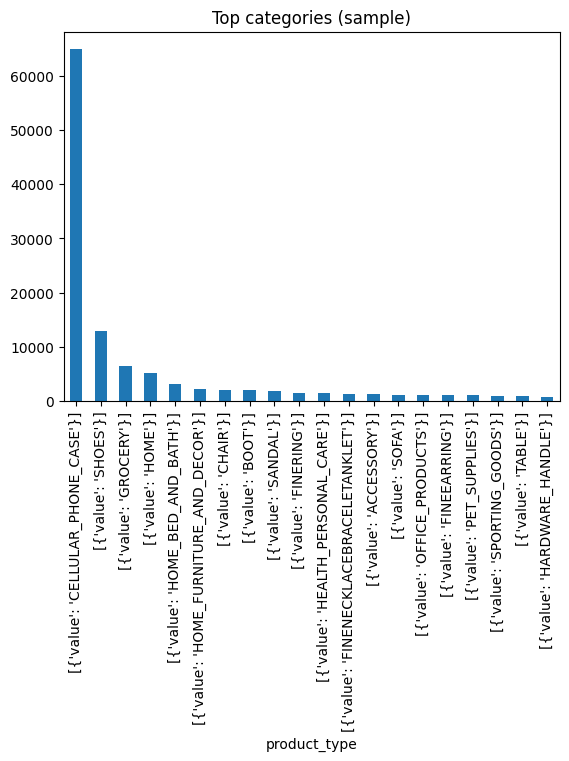

In [22]:
ax = df['product_type'].astype(str).value_counts().head(20).plot(kind='bar', title='Top categories (sample)')
#df.columns

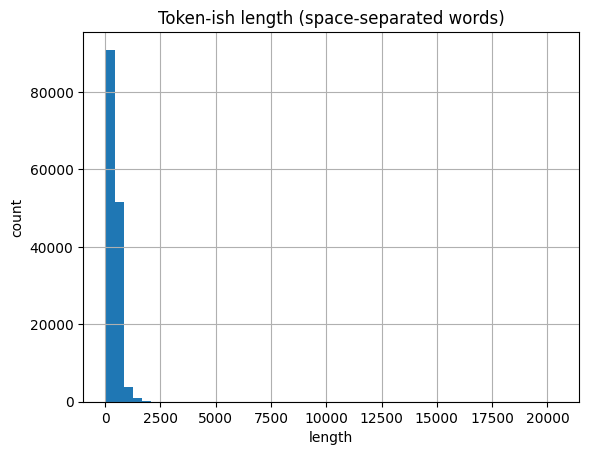

In [23]:
import matplotlib.pyplot as plt

df['len_text'] = df['text_for_embed'].str.split().apply(len)

ax = df['len_text'].hist(bins=50)
ax.set_title('Token-ish length (space-separated words)')
ax.set_xlabel('length'); ax.set_ylabel('count')
plt.show()


## 4. Embedding models wrapper
A common interface to swap models (e5/bge/MiniLM).

In [24]:
from sentence_transformers import SentenceTransformer
import torch, math

class Encoder:
    def __init__(self, model_name: str, device: str | None = None):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name, device=device)
    def encode(self, texts, batch_size=128, normalize=True):
        embs = self.model.encode(texts, batch_size=batch_size, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=normalize)
        return embs

encoders = {alias: Encoder(m) for alias, m in ENCODERS.items()}
list(encoders.keys())

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

['e5-base', 'bge-base', 'MiniLM']

# Create a small eval set (queries <->postives)

In [26]:


df_merged = df_merged.reset_index(drop=True)
df_merged['global_idx'] = np.arange(len(df_merged))

def make_query(row):
    t = extract_value(row['item_name']).lower()
    cat = extract_value(row['product_type']).lower()
    return f"{cat} {t}".strip()

sample = df_merged.sample(n=min(2000, len(df_merged)), random_state=SEED).reset_index(drop=True)
sample['query'] = sample.apply(make_query, axis=1)
pos = sample['global_idx'].to_numpy()

# Compute embeddings per pre-trained model

In [27]:

def prep_docs(texts, name):
    # e5/bge like "passage: "; MiniLM can work raw
    if 'e5' in name or 'bge' in name:
        return [f"passage: {t}" for t in texts]
    return texts

def prep_queries(texts, name):
    if 'e5' in name or 'bge' in name:
        return [f"query: {t}" for t in texts]
    return texts
def run_encode(enc, texts, normalize=True, batch_size=128):
    # SentenceTransformer models
    if hasattr(enc, "encode"):
        sig = enc.encode.__code__.co_varnames
        if "convert_to_numpy" in sig:
            return enc.encode(
                texts,
                convert_to_numpy=True,
                normalize_embeddings=normalize,
                batch_size=batch_size,
                show_progress_bar=True
            )
        else:
            # Plain .encode() (e.g. HuggingFace model directly)
            out = enc.encode(texts)
            return np.array(out)
    else:
        raise ValueError(f"Unknown encoder type: {type(enc)}")

docs_text = df_merged['text_for_embed_aug'].astype(str).tolist()
queries_text = sample['query'].astype(str).tolist()

EMB = {}
for name, enc in encoders.items():
    D_texts = prep_docs(docs_text, name)      # adds "passage: " for e5/bge
    Q_texts = prep_queries(queries_text, name)# adds "query: " for e5/bge
    print(f"Encoding with {name} ...")
    EMB[(name,'docs')] = run_encode(enc, D_texts)
    EMB[(name,'queries')] = run_encode(enc, Q_texts)


print({k[0] for k in EMB.keys()})

Encoding with e5-base ...

Batches:   0%|          | 0/1269 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Encoding with bge-base ...

Batches:   0%|          | 0/1269 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Encoding with MiniLM ...

Batches:   0%|          | 0/1269 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

{'bge-base', 'e5-base', 'MiniLM'}

# Build Queries and Training Samples

In [28]:
# ----------------- A) QUERIES + TRAINING SAMPLES -----------------
import numpy as np, pandas as pd, random, faiss, os, math
from datetime import datetime, timezone
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity

# 0) Config
BEST = "e5-base"  # alias in your ENCODERS/encoders
FT_INFO_DIR = "ft_infonce_e5"
FT_TRIPLET_DIR = "ft_triplet_e5"

# Seed
try:
    SEED
except NameError:
    SEED = 42
random.seed(SEED); np.random.seed(SEED)

# 1) Cleaning with your extract_value
def clean(s):
    try:
        return extract_value(s).strip().lower()
    except Exception:
        return str(s).strip().lower()

df_merged = df_merged.reset_index(drop=True)
if "global_idx" not in df_merged.columns:
    df_merged["global_idx"] = np.arange(len(df_merged))

# cleaned fields for query synthesis & category-aware negatives
df_merged["product_type_c"] = df_merged["product_type"].apply(clean)
df_merged["item_name_c"]    = df_merged["item_name"].apply(clean)
df_merged["brand_c"]        = df_merged.get("brand", "").apply(clean) if "brand" in df_merged else ""
df_merged["color_c"]        = df_merged.get("color", "").apply(clean) if "color" in df_merged else ""
df_merged["style_c"]        = df_merged.get("style", "").apply(clean) if "style" in df_merged else ""

# 2) Query synthesizer (short / realistic), consistent with your text_for_embed_aug style
def synth_query(row):
    parts = []
    for k in ["brand_c","color_c","item_name_c","product_type_c","style_c"]:
        v = str(row.get(k, "")).strip()
        if v and v.lower() != "nan":
            parts.append(v)
    # de-dup tokens, keep order
    seen = set(); toks = []
    for t in " ".join(parts).split():
        tl = t.lower()
        if tl not in seen:
            toks.append(t); seen.add(tl)
    return " ".join(toks)

# 3) Build df_q (≈2000 queries; each points to its own product as positive)
df_q = df_merged.sample(n=min(2000, len(df_merged)), random_state=SEED).reset_index(drop=True)
df_q["query"]  = df_q.apply(synth_query, axis=1).str.strip()
df_q["pos_id"] = df_q["global_idx"].astype(int)
df_q["qid"]    = np.arange(len(df_q))
df_q           = df_q[["qid","query","pos_id","product_type_c"]]

# 4) Mining space = BEST encoder
docs_text = df_merged["text_for_embed_aug"].astype(str).fillna("").tolist()
doc_ids   = df_merged["global_idx"].astype(int).tolist()
doc_cats  = df_merged["product_type_c"].astype(str).tolist()

# Use your encoders + run_encode + prep_* helpers
enc_best = encoders[BEST]
D_best = run_encode(enc_best, prep_docs(docs_text, BEST), normalize=True, batch_size=128)

# FAISS index in cosine space (normalize → IP)
dim = D_best.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(D_best)

# (Re)encode the queries for df_q
q_texts = df_q["query"].astype(str).tolist()
Q_best = run_encode(enc_best, prep_queries(q_texts, BEST), normalize=True, batch_size=128)

# helper: topK ids for q-vector
def ann_ids_for_vec(q_vec, topk=120):
    _, I = index.search(q_vec.reshape(1,-1), topk)
    return [doc_ids[i] for i in I[0]]

# same-category first; then fill with global hard
def mine_negs_for_row(row_i, need=5, pool=120):
    pos_id = int(df_q.iloc[row_i]["pos_id"])
    qcat   = df_q.iloc[row_i]["product_type_c"]
    cands  = ann_ids_for_vec(Q_best[row_i], topk=pool)
    cands  = [pid for pid in cands if pid != pos_id]
    same   = [pid for pid in cands if doc_cats[pid] == qcat]
    negs   = same[:need]
    if len(negs) < need:
        for pid in cands:
            if pid not in negs:
                negs.append(pid)
            if len(negs) == need:
                break
    return negs

# 5) Build Pairs (InfoNCE) and Triplets (TripletLoss) with your prefixing
doc_text_lookup = df_merged["text_for_embed_aug"].astype(str).fillna("")
pairs, triplets = [], []
NUM_NEG = 5

for i in range(len(df_q)):
    q_raw   = df_q.iloc[i]["query"]
    pos_id  = int(df_q.iloc[i]["pos_id"])
    pos_raw = doc_text_lookup.iloc[pos_id]
    neg_ids = mine_negs_for_row(i, need=NUM_NEG, pool=120)
    neg_raw = [doc_text_lookup.iloc[pid] for pid in neg_ids]

    q_p    = prep_queries([q_raw], BEST)[0]
    pos_p  = prep_docs([pos_raw], BEST)[0]
    neg_ps = prep_docs(neg_raw, BEST)

    pairs.append((q_p, pos_p))
    for n in neg_ps:
        triplets.append((q_p, pos_p, n))

print(f"Built {len(pairs)} pairs and {len(triplets)} triplets for {BEST}.")


Batches:   0%|          | 0/1269 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Built 2000 pairs and 10000 triplets for e5-base.

# Fine tune model InfoNCE-> Tripletloss

In [32]:
# ----------------- B) FINE-TUNE (InfoNCE → Triplet) -----------------
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader
os.environ["WANDB_DISABLED"] = "true"          # fully turns off wandb
os.environ["WANDB_MODE"] = "disabled"          # belt & suspenders
# os.environ["TOKENIZERS_PARALLELISM"] = "false" # optional: silence HF tokenizer warnings

# InfoNCE warm-up
model = SentenceTransformer(enc_best.model_name)
ex_pairs = [InputExample(texts=[q, p]) for (q, p) in pairs]
dl_pairs = DataLoader(ex_pairs, batch_size=64, shuffle=True, drop_last=True)
loss_infonce = losses.MultipleNegativesRankingLoss(model)
model.fit(train_objectives=[(dl_pairs, loss_infonce)],
          epochs=1, warmup_steps=500, use_amp=True,
          show_progress_bar=True, output_path=FT_INFO_DIR)

# Triplet pass (hard negatives)
model_t = SentenceTransformer(FT_INFO_DIR)
ex_trips = [InputExample(texts=[q, pos, neg]) for (q, pos, neg) in triplets]
dl_trips = DataLoader(ex_trips, batch_size=32, shuffle=True, drop_last=True)
triplet_loss = losses.TripletLoss(model_t,
    distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE, triplet_margin=0.2)
model_t.fit(train_objectives=[(dl_trips, triplet_loss)],
            epochs=1, warmup_steps=300, use_amp=True,
            show_progress_bar=True, output_path=FT_TRIPLET_DIR)

print("Saved fine-tuned model:", FT_TRIPLET_DIR)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Saved fine-tuned model: ft_triplet_e5

# Embed with fine tuned model and compare metrics

In [33]:
# ----------------- C) METRICS (Recall@10, nDCG@10) -----------------
# Helpers from your notebook:
def build_ip_index(doc_emb: np.ndarray) -> faiss.Index:
    doc = doc_emb.astype('float32').copy()
    faiss.normalize_L2(doc)
    index = faiss.IndexFlatIP(doc.shape[1])
    index.add(doc)
    return index

def topk_search(index: faiss.Index, q_emb: np.ndarray, k: int = 10):
    q = q_emb.astype('float32').copy()
    faiss.normalize_L2(q)
    D, I = index.search(q, k)
    return D, I

def recall_at_k_from_indices(I: np.ndarray, pos: np.ndarray) -> float:
    return float((I == pos[:, None]).any(axis=1).mean())

def ndcg_at_k_from_indices(I: np.ndarray, pos: np.ndarray) -> float:
    match = (I == pos[:, None])
    found = match.any(axis=1)
    rank = np.where(found, match.argmax(axis=1), -1)
    dcg = np.where(found, 1.0 / np.log2(rank + 2.0), 0.0)
    return float(dcg.mean())

# Baseline (BEST)
D_base = D_best  # from section A
idx_base = build_ip_index(D_base)
Q_base  = Q_best
# positives array = positions in docs array; here global_idx == row position
pos = df_q["pos_id"].to_numpy(dtype=int)

k = 10
_, I_base = topk_search(idx_base, Q_base, k=k)
r_base = recall_at_k_from_indices(I_base, pos)
n_base = ndcg_at_k_from_indices(I_base, pos)

# Fine-tuned
ft = SentenceTransformer(FT_TRIPLET_DIR)
D_ft = run_encode(ft, prep_docs(docs_text, BEST), normalize=True, batch_size=128)
Q_ft = run_encode(ft, prep_queries(q_texts, BEST), normalize=True, batch_size=128)

idx_ft = build_ip_index(D_ft)
_, I_ft = topk_search(idx_ft, Q_ft, k=k)
r_ft = recall_at_k_from_indices(I_ft, pos)
n_ft = ndcg_at_k_from_indices(I_ft, pos)

pd.DataFrame([
    {"model": f"BASE({BEST})", "queries": len(df_q), f"Recall@{k}": r_base, f"nDCG@{k}": n_base},
    {"model": f"FT({BEST})",   "queries": len(df_q), f"Recall@{k}": r_ft,   f"nDCG@{k}": n_ft},
    {"model": "Δ (FT - BASE)", "queries": len(df_q), f"Recall@{k}": r_ft - r_base, f"nDCG@{k}": n_ft - n_base},
])


/tmp/ipython-input-1559013386.py:23: RuntimeWarning: divide by zero encountered in divide
  dcg = np.where(found, 1.0 / np.log2(rank + 2.0), 0.0)


,model,queries,Recall@10,nDCG@10
0,BASE(e5-base),2000,0.6855,0.523645
1,FT(e5-base),2000,0.9310,0.851989
2,Δ (FT - BASE),2000,0.2455,0.328345


# Intra/Inter Cosine analysis with fine tuned embeddings

In [34]:
# ----------------- D) INTER/INTRA COSINE (on D_ft) -----------------
from sklearn.metrics.pairwise import cosine_similarity

# Build labels once (full corpus)
labels_full = df_merged["product_type"].apply(extract_value).str.strip().replace('', 'other').to_numpy()

# Subset for analysis
N = min(2000, len(docs_text))
rng = np.random.default_rng(SEED)
subset_idx = rng.choice(len(docs_text), size=N, replace=False)
labels_sub = labels_full[subset_idx]

# Use fine-tuned embeddings (normalized already by run_encode)
emb_sub = D_ft[subset_idx]

def inter_intra_scores(emb_sub, labels_sub):
    sim = cosine_similarity(emb_sub)
    intra, inter = [], []
    for i in range(len(emb_sub)):
        same = (labels_sub == labels_sub[i])
        diff = ~same
        # intra (exclude self)
        if same.sum() > 1:
            m_intra = (sim[i, same].sum() - 1.0) / (same.sum() - 1)
        else:
            m_intra = np.nan
        m_inter = sim[i, diff].mean() if diff.any() else np.nan
        intra.append(m_intra); inter.append(m_inter)
    intra = np.array([x for x in intra if not np.isnan(x)])
    inter = np.array([x for x in inter if not np.isnan(x)])
    return intra.mean(), inter.mean(), (intra.mean() - inter.mean())

intra_mean, inter_mean, delta = inter_intra_scores(emb_sub, labels_sub)
print({"FT_intra_cos": float(intra_mean), "FT_inter_cos": float(inter_mean), "Δ(intra-inter)": float(delta)})


{'FT_intra_cos': 0.1103637509145, 'FT_inter_cos': 0.04334906116127968, 'Δ(intra-inter)': 0.06701468975322032}

# UMAP Visualization

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


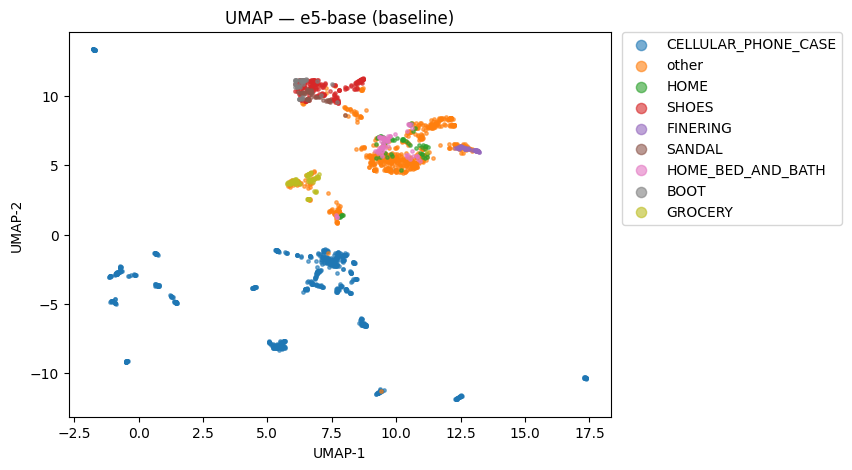

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


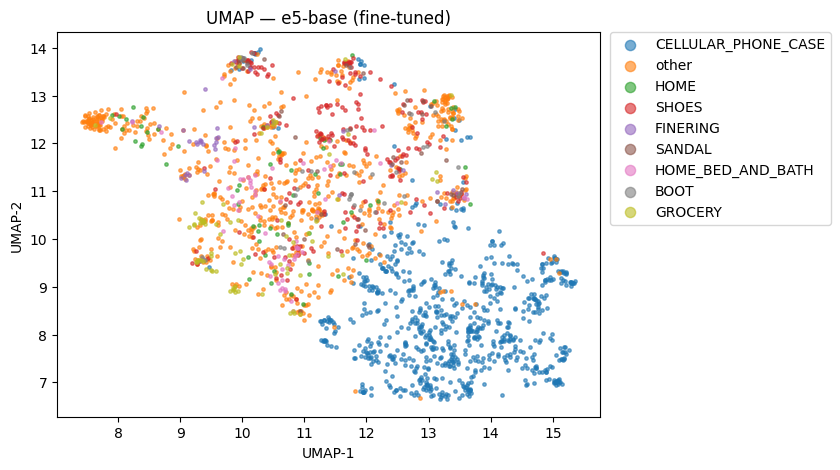

In [36]:
# ==== UMAP for e5-base vs fine-tuned e5 ====
!pip -q install umap-learn
import umap, matplotlib.pyplot as plt
import numpy as np, pandas as pd, os

# --- Config / helpers ---
try:
    SEED
except NameError:
    SEED = 42
rng = np.random.default_rng(SEED)

BEST = "e5-base"                # baseline encoder name (matches your encoders/EMB keys)
FT_TRIPLET_DIR = "ft_triplet_e5"  # change if your FT path differs (e.g., "ft_triplet")

def ensure_base_doc_emb():
    """Get baseline doc embeddings aligned with df_merged order, using your cache if present."""
    docs_text = df_merged["text_for_embed_aug"].astype(str).fillna("").tolist()
    # Use precomputed if available and length matches; else re-encode
    if (BEST, "docs") in EMB and EMB[(BEST, "docs")].shape[0] == len(docs_text):
        return EMB[(BEST, "docs")]
    D = run_encode(encoders[BEST], prep_docs(docs_text, BEST), normalize=True, batch_size=128)
    EMB[(BEST, "docs")] = D
    return D

def get_ft_doc_emb():
    """Encode docs with the fine-tuned model."""
    assert os.path.isdir(FT_TRIPLET_DIR), f"Fine-tuned model not found: {FT_TRIPLET_DIR}"
    ft = SentenceTransformer(FT_TRIPLET_DIR)
    docs_text = df_merged["text_for_embed_aug"].astype(str).fillna("").tolist()
    D = run_encode(ft, prep_docs(docs_text, BEST), normalize=True, batch_size=128)
    EMB[(f"{BEST}-ft", "docs")] = D
    return D

def get_labels_for_subset(df_sub):
    return df_sub["product_type"].apply(extract_value).str.strip().replace("", "other").tolist()

def umap_plot(emb_sub, labels, title, n_neighbors=30, min_dist=0.1):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=SEED)
    Z = reducer.fit_transform(emb_sub)
    cats = pd.Series(labels).fillna("")
    top = cats.value_counts().head(8).index
    col = cats.apply(lambda x: x if x in top else "other")
    fig, ax = plt.subplots(figsize=(7, 5))
    for c in col.unique():
        idx = (col == c).values
        ax.scatter(Z[idx, 0], Z[idx, 1], s=6, alpha=0.6, label=c)
    ax.legend(markerscale=3, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    ax.set_title(title)
    ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
    plt.show()

# --- Choose a consistent subset of docs to visualize ---
if "sample" in globals():
    # Use your existing sample
    subset_df = sample.copy()
else:
    # Fallback: make a reproducible subset
    subset_df = df_merged.sample(n=min(2000, len(df_merged)), random_state=SEED).reset_index(drop=True)

# Ensure we have a stable index to select rows from embedding matrices
if "global_idx" not in df_merged.columns:
    df_merged = df_merged.reset_index(drop=True)
    df_merged["global_idx"] = np.arange(len(df_merged))

subset_idx = subset_df["global_idx"].to_numpy()
labels = get_labels_for_subset(subset_df)

# --- Get embeddings for BASE and FT, then plot ---
from sentence_transformers import SentenceTransformer

D_base = ensure_base_doc_emb()
D_ft   = get_ft_doc_emb()

# Guard against out-of-bounds indices
valid = subset_idx[(subset_idx >= 0) & (subset_idx < D_base.shape[0])]
emb_base_sub = D_base[valid]
emb_ft_sub   = D_ft[valid]
labels_sub   = [labels[i] for i,_ in enumerate(valid)]  # same order as valid

umap_plot(emb_base_sub, labels_sub, title=f"UMAP — {BEST} (baseline)")
umap_plot(emb_ft_sub,   labels_sub, title=f"UMAP — {BEST} (fine-tuned)")


# Save fined tuned embeddings to drive

In [35]:
# ----------------- E) EXPORT FT EMBEDDINGS TO DRIVE -----------------
from google.colab import drive
from pathlib import Path
import json

drive.mount('/content/drive')

# Build export DataFrame (same columns as you used before)
export_cols = ['item_id', 'item_name', 'product_type', 'text_for_embed_aug', 'image_url']
meta = df_merged[export_cols].copy()
meta['item_name']    = meta['item_name'].apply(extract_value).str.strip()
meta['product_type'] = meta['product_type'].apply(extract_value).str.strip()

# Attach FT embedding (list)
meta["embedding"] = [vec.tolist() for vec in D_ft]

# Timestamped filenames
ts = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
run_id = f"{BEST}-ft-{ts}"   # e.g., e5-base-ft-20250905T044455Z

drive_folder = Path("/content/drive/MyDrive/abo_project/embeds") / BEST
drive_folder.mkdir(parents=True, exist_ok=True)

parquet_path = drive_folder / f"products_{run_id}.parquet"
meta.to_parquet(parquet_path, index=False)

manifest = {
    "run_id": run_id,
    "timestamp_utc": ts,
    "model_base": enc_best.model_name,
    "fine_tuned_path": FT_TRIPLET_DIR,
    "rows": int(len(meta)),
    "embedding_dim": int(D_ft.shape[1]) if len(meta) else None,
    "columns": list(meta.columns),
}
with open(drive_folder / f"manifest_{run_id}.json", "w") as f:
    json.dump(manifest, f, indent=2)

# Optional pointer to latest
with open(drive_folder / "latest.txt", "w") as f:
    f.write(run_id + "\n")

print("Saved:")
print(" - Parquet :", parquet_path)
print(" - Manifest:", drive_folder / f"manifest_{run_id}.json")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saved:

- Parquet : /content/drive/MyDrive/abo_project/embeds/e5-base/products_e5-base-ft-20250906T184857Z.parquet

- Manifest: /content/drive/MyDrive/abo_project/embeds/e5-base/manifest_e5-base-ft-20250906T184857Z.json

## 11. Next steps
- Replace synthetic queries with a labeled eval set (query → relevant product IDs).
- Try **hybrid search**: BM25 vs vector, score fusion.
- Add a **cross-encoder reranker** on top-K and re-measure metrics.
- Add **image captions** and compare text-only vs text+captions.
- (Optional) Try quantized encoders for speed; log latency per model.